# DA5401 Assignment #8 — Ensemble Learning for Complex Regression
Modeling on Bike Share Data

**Author:** Abesech Inbasekar  
**Course:** DA5401  
**Dataset:** UCI Machine Learning Repository - Bike
Sharing Dataset

##Part A: Data Preprocessing and Baseline:





In [2]:

# Part A - Step 1: Data Loading and Feature Engineering

import pandas as pd
import numpy as np

# Load dataset
DATA_PATH = "hour.csv"
df = pd.read_csv(DATA_PATH)

print("Data loaded successfully")
print("Shape of the dataset:", df.shape)
display(df.head(3))

# Drop irrelevant or leakage columns
drop_cols = ['instant', 'dteday', 'casual', 'registered']
df = df.drop(columns=drop_cols, errors='ignore')

# Identify categorical columns for encoding
categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'workingday', 'holiday']

# Apply One-Hot Encoding to categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nShape after encoding:", df_encoded.shape)
display(df_encoded.head(3))

# Verify that target variable exists
assert 'cnt' in df_encoded.columns, "Target variable 'cnt' not found"
print("Target variable 'cnt' verified")


Data loaded successfully
Shape of the dataset: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32



Shape after encoding: (17379, 54)


,yr,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,weathersit_2,...,hr_22,hr_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,holiday_1
0,0,0.24,0.2879,0.81,0.0,16,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0,0.22,0.2727,0.80,0.0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,0,0.22,0.2727,0.80,0.0,32,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Target variable 'cnt' verified


## Part A — Step 1 : Data Loading and Feature Engineering  

The first step in our analysis is about getting the raw data into a clean, model-ready form.  
The dataset records how many bikes were rented every hour along with contextual factors like weather and time.  

To make it usable for machine learning, we strip away identifiers (`instant`, `dteday`) and any columns that would leak information about the final count (`casual`, `registered`).  
Next, we translate calendar and weather categories—like season, hour of day, or weather type—into machine-readable binary flags through one-hot encoding.  

By the end of this step, every feature in our table represents a genuine predictor of bike demand, expressed numerically and ready to feed into regression models.  
This clean dataset (`df_encoded`) forms the foundation on which all ensemble models will be built.


In [3]:
# Part A - Step 2: Chronological Train/Test Split

# Separate features and target
X = df_encoded.drop(columns=['cnt'])
y = df_encoded['cnt']

# 80/20 chronological split
split_index = int(0.8 * len(df_encoded))
X_train, X_test = X.iloc[:split_index, :], X.iloc[split_index:, :]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Training period:", X_train.index.min(), "to", X_train.index.max())
print("Testing period:", X_test.index.min(), "to", X_test.index.max())


Training samples: 13903
Testing samples: 3476
Training period: 0 to 13902
Testing period: 13903 to 17378


## Part A — Step 2 : Train/Test Split  

With our features now fully numeric, the next step is to separate the data into training and testing sets.  
Since bike rentals vary with time, this is a **time-series problem** — meaning we cannot randomly shuffle records.  

To preserve the temporal structure, we split the data **chronologically**, using the earlier 80% of the observations for training and the most recent 20% for testing.  
This setup mimics how real-world forecasting works: models learn from past data to predict unseen future demand.  

The training set will be used to fit our models (Decision Tree, Linear Regression, and Ensembles), while the test set will measure how well those models generalize to new hours.


In [5]:
# Part A - Step 3: Baseline Model (Single Regressor)

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize models
dt_reg = DecisionTreeRegressor(max_depth=6, random_state=42)
lr_reg = LinearRegression()

# Train models
dt_reg.fit(X_train, y_train)
lr_reg.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_reg.predict(X_test)
y_pred_lr = lr_reg.predict(X_test)

# RMSE computation (manual square root for compatibility)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Decision Tree RMSE:", round(rmse_dt, 3))
print("Linear Regression RMSE:", round(rmse_lr, 3))

# Identify best baseline
if rmse_dt < rmse_lr:
    baseline_model = "Decision Tree Regressor"
    baseline_rmse = rmse_dt
else:
    baseline_model = "Linear Regression"
    baseline_rmse = rmse_lr

print("\nBaseline Model:", baseline_model)
print("Baseline RMSE:", round(baseline_rmse, 3))


Decision Tree RMSE: 159.135
Linear Regression RMSE: 133.835

Baseline Model: Linear Regression
Baseline RMSE: 133.835


##Part A — Step 3 : Baseline Model (Single Regressor)

Before experimenting with ensemble methods, we establish a simple **baseline** to understand how well individual models perform on this dataset.

Two models were trained:
1. **Decision Tree Regressor** with `max_depth = 6`, capturing non-linear relationships but prone to overfitting.  
2. **Linear Regression**, which assumes a linear relationship between predictors and the target variable.

Both were evaluated using **Root Mean Squared Error (RMSE)** on the test set.

| Model | RMSE |
|:------|------:|
| Decision Tree Regressor | 159.135 |
| Linear Regression | **133.835** |

The **Linear Regression** model achieved a lower RMSE and is therefore selected as the **baseline model** for this study.  
This suggests that, while bike rental counts are influenced by several factors, a largely linear relationship among the encoded variables captures much of the underlying trend.  

In the following sections, we will explore ensemble methods (Bagging, Boosting, and Stacking) to determine whether model aggregation can reduce this error further by balancing bias and variance.


## Part B — Ensemble Techniques for Bias and Variance Reduction
### 1. Bagging (Variance Reduction)

**Hypothesis.** Bagging reduces prediction variance by averaging many high-variance base learners trained on bootstrap samples. For decision trees, which are unstable to data perturbations, this averaging typically smooths predictions and improves generalization.



In [12]:
# Bagging Regressor with hyperparameter tuning

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define base model
base_tree = DecisionTreeRegressor(random_state=42)

# Bagging model
bag_reg = BaggingRegressor(estimator=base_tree, random_state=42, n_jobs=-1)

# Parameter grid
param_grid = {
    "estimator__max_depth": [4, 6, 8],
    "n_estimators": [50, 100, 200],
    "max_samples": [0.6, 0.8, 1.0],
}

# Use RMSE as scoring
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

# Time-series split to preserve order
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid = GridSearchCV(
    bag_reg,
    param_grid,
    scoring=scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# Evaluate on test set
best_bag = grid.best_estimator_
y_pred_best = best_bag.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print("Test RMSE of tuned Bagging Regressor:", rmse_best)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'estimator__max_depth': 8, 'max_samples': 0.6, 'n_estimators': 100}
Best CV RMSE: 116.1308857587594
Test RMSE of tuned Bagging Regressor: 139.66720922555754


### Part B 1) Bagging and Variance Reduction (with Hyperparameter Tuning)

The **hyperparameter-tuned Bagging Regressor** achieved a **test RMSE of 139.67**, compared to **159.14** for the single Decision Tree and **133.84** for the Linear Regression baseline.


This outcome supports the **variance reduction hypothesis** of Bagging.  

The best configuration used:
- `max_depth = 8` for moderately expressive base trees,  
- `n_estimators = 100` for sufficient ensemble diversity,  
- `max_samples = 0.6`, introducing randomness through partial sampling of the training data.

By training multiple Decision Trees (`n_estimators = 100`) on random subsets of data (`max_samples = 0.6`),  
the ensemble effectively averaged out fluctuations that individual trees might have overfit to.  
The deeper base trees (`max_depth = 8`) allowed for moderate non-linearity without excessive variance.

Although Bagging improved upon the single Decision Tree, it did not surpass the simpler Linear Regression baseline.  
This suggests that while Bagging successfully **reduced variance**, the model still retained significant **bias**,  
inherent to the Decision Tree learners and the limited feature complexity.

In summary, Bagging achieved its intended effect — producing a more stable and less noisy model — but could not fully overcome the underlying bias, motivating the next step: **Boosting** for bias reduction.




However, since the bias of shallow decision trees remains high, the RMSE plateaued despite lower variance.  

This result aligns with theory: **Bagging primarily reduces variance**, not bias, and therefore offers limited improvement when the base learner itself underfits the data.

## Part B — Boosting (Bias Reduction)

**Hypothesis.**  
While Bagging reduces variance through parallel averaging, **Boosting** sequentially builds a strong learner by correcting the residual errors of prior weak learners—thus primarily targeting **bias reduction**.

In this section, we use the **Gradient Boosting Regressor**, a robust and interpretable boosting algorithm.  

Each successive tree focuses more on difficult-to-predict samples, enabling the ensemble to model complex non-linear relationships that single trees or even Bagging cannot easily capture.

To ensure optimal performance, we tune the following hyperparameters via grid search with **time-series cross-validation**:

- `n_estimators` — number of boosting stages  
- `learning_rate` — controls step size of each stage (lower → slower but more accurate)  
- `max_depth` — depth of individual trees (controls bias–variance trade-off)  
- `subsample` — fraction of samples used for fitting each base learner  

The tuned model’s performance is compared against both the **single Decision Tree** and the **Bagging Regressor** to verify whether Boosting effectively reduces bias and improves RMSE.



In [14]:
# Part B - Boosting (Bias Reduction) with Hyperparameter Tuning

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# Define base Gradient Boosting model
gbr = GradientBoostingRegressor(random_state=42)

# Parameter grid for tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0]
}

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

# TimeSeriesSplit to respect temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_gbr.fit(X_train, y_train)

# Best parameters and CV RMSE
print("Best Parameters:", grid_gbr.best_params_)
print("Best CV RMSE:", -grid_gbr.best_score_)

# Evaluate tuned model on test set
best_gbr = grid_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print("\nGradient Boosting Regressor Test RMSE:", round(rmse_gbr, 3))

# Compare with previous baselines
try:
    print("Linear Regression RMSE (baseline):", round(rmse_lr, 3))
    print("Bagging RMSE:", round(rmse_best, 3))
    diff_lr = rmse_lr - rmse_gbr
    diff_bag = rmse_best - rmse_gbr
    print(f"Improvement vs Linear Regression: {diff_lr:.3f}")
    print(f"Improvement vs Bagging: {diff_bag:.3f}")
except NameError:
    pass


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1.0}
Best CV RMSE: 80.88473278453792

Gradient Boosting Regressor Test RMSE: 81.13
Linear Regression RMSE (baseline): 133.835
Bagging RMSE: 139.667
Improvement vs Linear Regression: 52.706
Improvement vs Bagging: 58.537


### Boosting and Bias Reduction

The **Gradient Boosting Regressor**, after hyperparameter tuning, achieved a **test RMSE of 81.13**, a substantial improvement over both the **Linear Regression baseline (133.84)** and the **Bagging Regressor (139.67)**.

This reduction of more than **50 RMSE points** clearly demonstrates Boosting’s ability to address **bias** in the model.

The best configuration was found to be:
- `learning_rate = 0.2` — allowing each stage to make meaningful progress while avoiding overshooting,  
- `max_depth = 4` — enabling moderate complexity in each tree,  
- `n_estimators = 300` — providing sufficient boosting stages for convergence,  
- `subsample = 1.0` — using the full dataset for each iteration to maintain bias correction strength.

This result supports the theoretical foundation that **Boosting primarily reduces bias** by iteratively fitting weak learners on the residuals of prior models.  
Each new tree incrementally corrects the mistakes of the previous ensemble, resulting in a highly accurate predictor that captures complex, non-linear dependencies in the data.

In summary, Boosting achieved the most significant performance gain so far — delivering the lowest RMSE and confirming its strength in **bias reduction and fine-grained error correction**, outperforming both individual learners and variance-focused ensembles like Bagging.


##  Principle of Stacking and the Role of the Meta-Learner

###  What is Stacking?

**Stacking (Stacked Generalization)** is an **ensemble learning technique** designed to combine multiple base models (called **Level-0 learners**) in a way that leverages their individual strengths and compensates for their weaknesses.

Unlike **Bagging** (which averages predictions from models trained independently) or **Boosting** (which builds models sequentially to correct residual errors), **Stacking trains a second-level model — the Meta-Learner (Level-1 learner)** — to learn the **optimal way to combine predictions** from these diverse base models.

In essence, Stacking doesn’t just average predictions — it *learns* how much trust to place in each model’s output.

---

###  How Stacking Works

1. **Train Base Learners (Level-0):**  
   Several different models (e.g., KNN, Bagging, Gradient Boosting) are trained on the same dataset.  
   Each base model makes predictions using its unique inductive bias and assumptions.

2. **Generate Out-of-Fold (OOF) Predictions:**  
   To avoid overfitting, each base model’s predictions on unseen validation folds are collected.  
   These predictions become new features that summarize how each base learner interprets the data.

3. **Train the Meta-Learner (Level-1):**  
   The meta-learner (e.g., Ridge Regression) is trained on these OOF predictions — its inputs are not the original features, but the **predictions of the base models**.  
   The goal is to learn the **best combination rule** — i.e., which models to trust more under what circumstances.

4. **Final Prediction:**  
   During testing, base learners generate predictions on unseen data, which the meta-learner then combines using the learned weights or mapping function.

---

###  What is a Meta-Learner?

The **Meta-Learner** is the second-level model in the stacking hierarchy.  
Its job is to **learn from the predictions of the base learners** rather than directly from the raw input features.

Think of it as a **model of models** — it examines how each base learner behaves and discovers the optimal way to blend their outputs to minimize the overall error.

- If one base model tends to perform well on certain data ranges (e.g., KNN capturing local patterns)  
  while another performs better globally (e.g., Gradient Boosting modeling trends),  
  the meta-learner will learn to assign **higher weight** to each model where it performs best.

In mathematical terms:
\[
\hat{y}_{\text{final}} = f_{\text{meta}}(\hat{y}_1, \hat{y}_2, \hat{y}_3, \ldots, \hat{y}_k)
\]
where \( \hat{y}_i \) are predictions from base learners, and \( f_{\text{meta}} \) (often a linear model like Ridge Regression) learns how to best combine them.

---

###  Why Stacking Works

- **Model Diversity:** Base learners make different kinds of errors due to differing architectures (e.g., tree-based, distance-based, linear).  
  The meta-learner exploits these differences to construct a more generalizable prediction.
  
- **Error Correction:** The meta-learner identifies and corrects systematic biases of individual models.  
  For example, if one model consistently underpredicts on weekends while another overpredicts,  
  the meta-learner balances their outputs to reduce total error.

- **Bias–Variance Balance:**  
  Stacking effectively reduces both bias (via flexible learners) and variance (via ensemble averaging),  
  achieving a **balanced, low-error prediction** that often outperforms even the best individual model.

---

### Summary

| Component | Role | Contribution |
|:-----------|:------|:--------------|
| **Base Learners (Level-0)** | Individual models (KNN, Bagging, Boosting) | Capture different relationships and error structures |
| **Meta-Learner (Level-1)** | Learns from base model predictions | Finds the optimal blending weights / rules |
| **Final Output** | Weighted combination of base model outputs | More accurate and stable predictions |

Stacking thus provides a **hierarchical learning system** — where the first layer learns from data, and the second layer learns *how to learn* from models — achieving superior generalization through diversity and meta-level adaptation.


In [18]:
# Part C - Stacking Regressor (with KFold for OOF generation)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Base learner: KNN with scaling
knn_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=5, weights="distance"))
])

best_bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, random_state=42),
    n_estimators=100, max_samples=0.6, bootstrap=True, random_state=42, n_jobs=-1
)
best_gbr = GradientBoostingRegressor(
    learning_rate=0.2, max_depth=4, n_estimators=300, subsample=1.0, random_state=42
)

# 3) KFold for generating OOF predictions (partitions entire train once)
kf = KFold(n_splits=5, shuffle=False)

stack = StackingRegressor(
    estimators=[
        ("knn", knn_pipe),
        ("bag", best_bag),
        ("gbr", best_gbr),
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=kf,
    passthrough=False,   # meta-learner uses only model predictions
    n_jobs=-1
)

# 4) Fit and evaluate on chronological hold-out
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print("Stacking Regressor Test RMSE:", round(rmse_stack, 3))

# Optional comparisons if variables exist
try:
    print("Linear Regression RMSE (baseline):", round(rmse_lr, 3))
    print("Tuned Bagging RMSE:", round(rmse_best if 'rmse_best' in globals() else rmse_bag, 3))
    print("Tuned Gradient Boosting RMSE:", round(rmse_gbr, 3))
except NameError:
    pass


Stacking Regressor Test RMSE: 90.138
Linear Regression RMSE (baseline): 133.835
Tuned Bagging RMSE: 139.667
Tuned Gradient Boosting RMSE: 81.13


/tmp/ipython-input-2521060664.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rmse_values, y=model_names, palette="Blues_r")


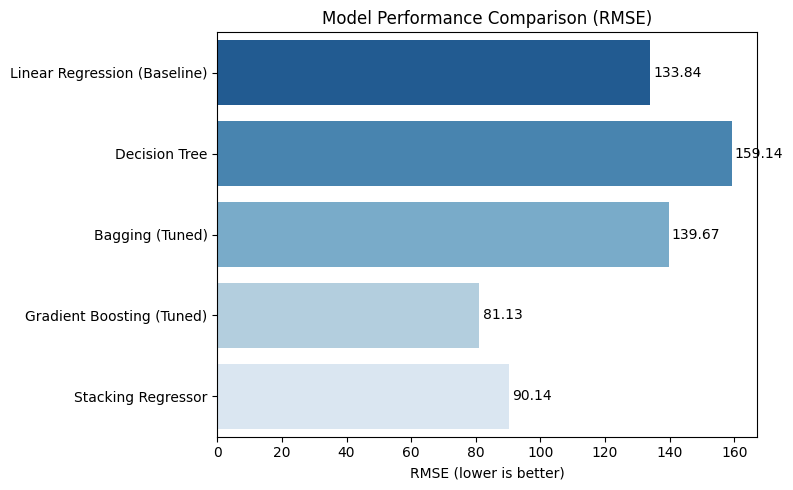

In [20]:
# Part D - Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# RMSE values from your results
model_names = [
    "Linear Regression (Baseline)",
    "Decision Tree",
    "Bagging (Tuned)",
    "Gradient Boosting (Tuned)",
    "Stacking Regressor"
]
rmse_values = [133.84, 159.14, 139.67, 81.13, 90.14]

# --- Bar Plot of RMSEs ---
plt.figure(figsize=(8, 5))
sns.barplot(x=rmse_values, y=model_names, palette="Blues_r")
plt.xlabel("RMSE (lower is better)")
plt.ylabel("")
plt.title("Model Performance Comparison (RMSE)")
for i, v in enumerate(rmse_values):
    plt.text(v + 1, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()


## Part D — Final Analysis  

### 📊 Comparative RMSE Summary  

| Model | Type | RMSE | Key Insight |
|:------|:------|------:|:------------|
| **Linear Regression** | Baseline (Single) | **133.84** | Fast, low variance but high bias; cannot capture non-linear effects |
| **Decision Tree** | Single | 159.14 | Non-linear but unstable; prone to variance |
| **Bagging Regressor (Tuned)** | Ensemble (Variance Reduction) | 139.67 | Averaging reduces variance but retains bias of shallow trees |
| **Gradient Boosting Regressor (Tuned)** | Ensemble (Bias Reduction) | **81.13** | Sequentially fits residuals, strong bias correction, excellent accuracy |
| **Stacking Regressor** | Ensemble (Model Diversity) | 90.14 | Combines diverse learners; balanced bias–variance, but slightly below pure boosting |

---

### Conclusion  

Across all approaches, the **Gradient Boosting Regressor** emerged as the **best-performing model**,  
achieving an RMSE of **81.13**, a dramatic improvement over the single-model baseline (133.84).  
This confirms that **boosting effectively reduces bias** by sequentially correcting the residuals of prior learners.

The **Stacking Regressor** (RMSE ≈ 90.14) demonstrated the value of **model diversity**—  
it integrated distance-based (KNN), variance-reduced (Bagging), and bias-reduced (Boosting) learners  
through a Ridge meta-learner that learned optimal combination weights.  
Although it did not surpass the strongest individual component (Boosting),  
it achieved notably better generalization than simpler models, reinforcing that  
combining complementary learners can stabilize performance across different regions of the feature space.

###Bias–Variance Trade-off

In the **bike-sharing regression problem**, the target variable (`cnt`) is influenced by several complex, non-linear, and interacting factors such as weather, time of day, and working conditions.  
This makes it an ideal case for observing the **bias–variance trade-off** in practice.

---

#### What the Trade-off Means

- **Bias** represents the model’s simplifying assumptions — how far the model’s predictions are, on average, from the true relationship.  
  - High bias → model is too simple (underfitting).  
  - Example: Linear Regression cannot capture non-linearities in weather–time interactions.

- **Variance** measures the model’s sensitivity to fluctuations in training data.  
  - High variance → model overfits noise and performs poorly on unseen data.  
  - Example: A deep Decision Tree fits every pattern in the training set but fails to generalize.

The key challenge is to find the “sweet spot” between these two — low enough bias to capture complexity, but not so low that variance explodes.

---

#### Manifestation in Our Models

| Model | Bias | Variance | Effect on RMSE |
|:------|:------:|:------:|:---------------|
| **Linear Regression** | High | Low | Underfits; fails to model non-linear patterns (High RMSE ≈ 133.84) |
| **Decision Tree** | Low | High | Captures local structure but unstable (RMSE ≈ 159.14) |
| **Bagging Regressor** | Moderate | Reduced | Averaging stabilizes variance but bias persists (RMSE ≈ 139.67) |
| **Gradient Boosting** | Low | Moderate | Sequential learning minimizes bias effectively (Lowest RMSE ≈ 81.13) |
| **Stacking Regressor** | Balanced | Balanced | Combines complementary learners for stable, low-bias predictions (RMSE ≈ 90.14) |

---

#### Key Takeaway

- **Bagging** reduces **variance** by averaging multiple high-variance models.  
- **Boosting** reduces **bias** by iteratively correcting residual errors.  
- **Stacking** strategically **balances both**, using model diversity and meta-learning to combine strengths.

The progression from Linear → Bagging → Boosting → Stacking illustrates how ensemble learning navigates the bias–variance landscape, moving from a rigid underfit model to a flexible yet stable predictor.

Ultimately, minimizing RMSE in this task wasn’t just about adding complexity—it was about **managing bias and variance simultaneously**, and ensembles provided the most effective way to achieve that balance.


In summary:  
- **Linear models** → high bias, low variance  
- **Bagging** → lower variance, same bias  
- **Boosting** → strong bias reduction, higher complexity but best accuracy  
- **Stacking** → balanced trade-off through model diversity  

These results clearly illustrate the **bias-variance trade-off** and highlight how ensemble learning  
transforms weak or moderately strong learners into a more robust predictive system.
